In [1]:
# Utils
import os
import gc
import json
import time
import numpy as np
import matplotlib.pyplot as plt

# Torch
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader, Subset

In [2]:
def use_device():
    """
    Checks the available device and returns it.

    Returns:
    - device: Available device.       
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    return device

In [3]:
def process_image(img, transpose=False, numpy=False):
    """
    Preprocess the images to displays them in a plot.

    Parameters:
    - img: The image to preprocess.
    - transpose: Bool value if the img needs to be transposed.
    - numpy: Flag to identify if the image is already in a numpy array.

    Returns:
    - img: The image preprocessed.       
    """        
    if transpose:
        if numpy is False:
            img = img.numpy()
        img = img.transpose((1, 2, 0)) # Transform (X, Y, Z) shape
    img = (img - img.min()) / (img.max() - img.min()) # Clip the image to [0, 255] values
    return img

In [4]:
def obj_variance(obj, type=None):
    """
    Display the maximum and minimum value in a given object.

    Parameters:
    - obj: A given object.
    - type: Object type. Can be "tensor" and "numpy".
    """

    if type == "tensor":
        tensor_min = torch.min(obj)
        tensor_max = torch.max(obj)
        
        print("Maximum value:", "{:.5f}".format(tensor_max.item()))
        print("Minimum value:", "{:.5f}".format(tensor_min.item()))
    else:
        numpy_min = "{:.5f}".format(np.max(obj))
        numpy_max = "{:.5f}".format(np.min(obj))
        
        print("Maximum value:", numpy_max)
        print("Minimum value:", numpy_min)

In [5]:
def normalize(image):
    """
    Normalise a given image.

    Parameters:
    - img: The image to be normalised.

    Returns:
    - img: The image normalised.       
    """

    mean = torch.Tensor([0.485, 0.456, 0.406])
    std = torch.Tensor([0.229, 0.224, 0.225])
    return (image - mean.type_as(image)[None,:,None,None]) / std.type_as(image)[None,:,None,None]


In [6]:
def get_uap(path, device):
    """
    Get the UAP perturbation file.

    Parameters:
    - path: Directory path of a given a UAP perturbation.
    - device: The device (CPU/GPU) to store the perturbation that will be loaded.

    Returns:
    - uap: UAP perturbation.       
    """

    uap = np.load(path)
    uap = torch.tensor(uap, device=device)
    return uap

In [7]:
def prepare_model(model_name, device):
    """
    Prepares a model for later usage.

    Parameters:
    - model_name: Name of the model that is going to be used.
    - device: The device (CPU/GPU) to store the model that will be loaded.

    Returns:
    - model: A pre-trained model ready to use.       
    """
     
    model = getattr(models, model_name.lower())(pretrained=True).to(device)
    return model

In [8]:
def get_dataloader(dataset, batch_size, num_images, shuffle=True):
    """
    Creates a PyTorch Dataloader for a given dataset.

    Parameters:
    - dataset: Direcorty path of the dataset that is going to be loaded.
    - batch_size: Batch size number.
    - num_images: Number of images that are going to be loaded.
    - shuffle: If the images are going to be shuffle or not (DEFAULT=True).

    Returns:
    - dataloader: A dataloader of a given dataset.
    - class_to_name: A dictionary mapping class indices to class names.
    """

    transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ])
    
    val_dataset =  datasets.ImageFolder(dataset, transform=transform)
    num_classes = len(val_dataset.classes)
    class_to_name = {i: class_name for i, class_name in enumerate(val_dataset.classes)}
    
    class_indices = {i: [] for i in range(num_classes)}
    for idx, (_, label) in enumerate(val_dataset.samples):
        class_indices[label].append(idx)
        
    samples_per_class = num_images // num_classes
    subset_indices = []
    
    for i in range(num_classes):
        class_subset_indices = np.random.choice(class_indices[i], samples_per_class, replace=False).tolist()
        subset_indices.extend(class_subset_indices)
        
    val_subset = Subset(val_dataset, subset_indices)
    dataloader = DataLoader(val_subset, batch_size=batch_size, shuffle=shuffle, num_workers=4)
    
    return dataloader, class_to_name

In [9]:
def get_adversarial_images(model, delta, dataloader, device):
    """
    Generates the adverasial images for a given model and dataset.

    Parameters:
    - model: Model to be use.
    - delta: Intensity of the perturbation.
    - dataloader: Dataloader to be use.
    - device: Device to be used to store in memory the adversarial images.

    Returns:
    - adv_dataset: Advesarial images that are missclassified.       
    - adv_classes: Classes of the missclassified advesarial images.
    - ori_classes: Original classes of the images.    
    """

    adv_dataset = []
    adv_classes = []
    ori_classes = []
    
    model.eval()    
    with torch.no_grad():
        for batch in dataloader:
            images, labels = batch
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(normalize(images))
            _, predicted = torch.max(outputs.data, 1)

            adv_images = torch.add(delta, images).clamp(0, 1)
            adv_outputs = model(normalize(adv_images))

            _, adv_predicted = torch.max(adv_outputs.data, 1)
                
            misclassified_indices = (predicted != adv_predicted).nonzero(as_tuple=True)[0]
            if misclassified_indices.numel() > 0:
                adv_dataset.append(adv_images[misclassified_indices].cpu())
                adv_classes.append(adv_predicted[misclassified_indices].cpu())
                ori_classes.append(labels[misclassified_indices].cpu())
                
            del images, labels, outputs, adv_images, adv_outputs, predicted, adv_predicted
            torch.cuda.empty_cache()
                
    return adv_dataset, adv_classes, ori_classes

In [10]:
device = use_device()

In [11]:
start_time = time.time()
uap = get_uap('UAP/UAP_VGG16.npy', device)
print(f"[INFO] UAP perturbation loaded. Time taken: {time.time() - start_time:.2f} seconds")

[INFO] UAP perturbation loaded. Time taken: 2.35 seconds


In [12]:
start_time = time.time()
model = prepare_model('VGG16', device)
print(f"[INFO] Model loaded. Time taken: {time.time() - start_time:.2f} seconds")

[INFO] Model loaded. Time taken: 1.09 seconds


In [13]:
start_time = time.time()
dataloader, class_names = get_dataloader('../Datasets/ImageNet100/Train', 2, 50000, shuffle=True)
print(f"[INFO] Dataloader created. Time taken: {time.time() - start_time:.2f} seconds")

[INFO] Dataloader created. Time taken: 0.33 seconds


### DEBUG

In [14]:
img, labels = next(iter(dataloader))

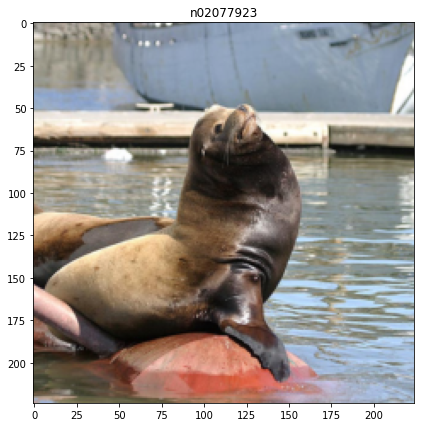

In [15]:
k = process_image(img[0], transpose=True, numpy=False)
plt.figure(figsize = (7,7))
plt.title(class_names[labels[0].item()])
plt.imshow(k)

### DEBUG

In [27]:
delta = torch.clamp(uap, -10/255, 10/255)

In [23]:
model.eval()    
with torch.no_grad():
    for batch in dataloader:
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)
        
        break

In [25]:
print(labels[0].item())

66


In [28]:
model.eval()    
with torch.no_grad():
    for batch in dataloader:
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(normalize(images))
        _, predicted = torch.max(outputs.data, 1)

        adv_images = torch.add(delta, images).clamp(0, 1)
        adv_outputs = model(normalize(adv_images))

        _, adv_predicted = torch.max(adv_outputs.data, 1)
        
        break

In [29]:
print(labels[0].item())

83


In [30]:
print(adv_predicted[0].item())

854
